In [2]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
from io import StringIO
from shapely.geometry import Point
# Use your own path here
#os.chdir("")

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
import censusdis.values as cev
from censusdis import states

import pickle
import numpy as np

pd.options.mode.chained_assignment = None

In [6]:
# Use your own path here
os.chdir("/Users/canyonfoot/Documents/python_proj/EPA-Hack-Day-Analysis")

from src.utils.utility_functions_anniez import (
    interpolate_multiple_buffers_advanced,
    compute_proportions
)

In [4]:
gpd.read_file("https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/UAC20/tl_rd22_us_uac20.zip")

,UACE20,GEOID20,NAME20,NAMELSAD20,LSAD20,MTFCC20,UATYP20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,67240,67240,"Pampa, TX","Pampa, TX Urban Area",67,G3500,U,S,21374659,0,+35.5451610,-100.9656498,"POLYGON ((-100.94529 35.53833, -100.94525 35.5..."
1,23230,23230,"Delta, CO","Delta, CO Urban Area",67,G3500,U,S,16126572,129608,+38.7454236,-108.0619343,"POLYGON ((-108.04131 38.74094, -108.04100 38.7..."
2,36001,36001,"Gunnison, CO","Gunnison, CO Urban Area",67,G3500,U,S,9468678,11725,+38.5405505,-106.9384998,"POLYGON ((-106.92674 38.53565, -106.92795 38.5..."
3,45775,45775,"Kuna, ID","Kuna, ID Urban Area",67,G3500,U,S,16384896,46009,+43.5010643,-116.4168990,"MULTIPOLYGON (((-116.39896 43.48833, -116.3988..."
4,05410,05410,"Basalt, CO","Basalt, CO Urban Area",67,G3500,U,S,9433311,68797,+39.3835983,-107.0807354,"MULTIPOLYGON (((-107.11050 39.40463, -107.1104..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,74908,74908,"Ridgway, PA","Ridgway, PA Urban Area",67,G3500,U,S,6495687,98944,+41.4294622,-078.7380986,"POLYGON ((-78.72689 41.42290, -78.72684 41.422..."
2641,96843,96843,"Wise--Norton, VA","Wise--Norton, VA Urban Area",67,G3500,U,S,28350106,95639,+36.9649058,-082.5955171,"POLYGON ((-82.56700 36.97083, -82.56706 36.970..."
2642,88921,88921,"Tullahoma, TN","Tullahoma, TN Urban Area",67,G3500,U,S,38296270,0,+35.3697423,-086.2140939,"MULTIPOLYGON (((-86.19416 35.34460, -86.19430 ..."
2643,60502,60502,"Mount Washington, KY","Mount Washington, KY Urban Area",67,G3500,U,S,33680478,168692,+38.0411866,-085.5702925,"MULTIPOLYGON (((-85.54262 38.03232, -85.54265 ..."


In [41]:
gdf_tract = gpd.read_file("data/processed/US_tract_census.geojson").to_crs(2263)
gdf_urban_all = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/UAC20/tl_rd22_us_uac20.zip").rename(columns = {"NAME20": "UA_NAME"}).to_crs(2263)
RMP_facilities = gpd.read_file("data/processed/facilities_geo.geojson").to_crs(2263)

In [44]:
gdf_urban_all["UACE"] = gdf_urban_all["UACE20"]
name_uace_map = {
    x['UA_NAME'] : x['UACE']
    for _,x in gdf_urban_all.iterrows()
}
gdf_urban_all["UACE"] =  gdf_urban_all["UACE"].astype("int")

In [45]:
sum_columns = ["total_pop", "white_pop", "hispanic_pop", "black_pop", 'pop_in_poverty','total_households','renter_households','total_housing_units','vacant_units']
mean_dict = {'total_households' : 'median_hh_income', 'total_housing_units' : 'median_home_value'}
prop_dict =  {"total_pop":["white_pop", 'hispanic_pop', "black_pop", 'pop_in_poverty'], "total_households": 'renter_households', "total_housing_units": 'vacant_units'}

In [46]:
gdf_tract.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
DATA_DIR = "data/cache_interpolated/"
urban_stats = interpolate_multiple_buffers_advanced(
    census_data = gdf_tract,
    facilities = gdf_urban_all,
    buffer_miles_list = [0], 
    census_vars_sum = sum_columns, 
    census_vars_mean = mean_dict, 
    file_dir = DATA_DIR, facility_index_name = 'UACE'
)
compute_proportions(urban_stats, prop_dict, [0])
urban_stats.tail()

=== Computing 0 radius ===
Data cleaned!
Geometries overlaid!
Finished computing sums!
Finished computing means!


,UACE,total_pop_buffer_0,white_pop_buffer_0,hispanic_pop_buffer_0,black_pop_buffer_0,pop_in_poverty_buffer_0,total_households_buffer_0,renter_households_buffer_0,total_housing_units_buffer_0,vacant_units_buffer_0,median_hh_income_buffer_0,median_home_value_buffer_0,white_pop_buffer_0_proportion,hispanic_pop_buffer_0_proportion,black_pop_buffer_0_proportion,pop_in_poverty_buffer_0_proportion,renter_households_buffer_0_proportion,vacant_units_buffer_0_proportion
2607,98074,28408.192505,24199.351680,665.126621,1407.167679,5944.746285,11971.469405,5255.728677,13534.403904,1562.934499,38338.131323,105132.322208,0.851844,0.023413,0.049534,0.209262,0.439021,0.115479
2608,98101,5063.531274,101.872519,4943.621390,0.000000,1657.209082,1590.673090,466.406165,1927.713488,337.040398,28430.199465,85543.879526,0.020119,0.976319,0.000000,0.327283,0.293213,0.174839
2609,98129,3003.675074,1612.619251,439.793653,792.571090,325.709562,1002.144718,280.264550,1040.151801,38.007083,69678.845005,201567.842152,0.536882,0.146419,0.263867,0.108437,0.279665,0.036540
2610,98182,44246.388764,34518.408008,5965.121123,1730.353580,7591.803396,19272.178094,4745.221142,24852.323912,5580.145818,38903.283262,100383.874109,0.780141,0.134816,0.039107,0.171580,0.246221,0.224532
2611,98209,1485.173454,1288.065134,46.176609,7.893765,71.351848,500.835490,59.651024,518.333233,17.497743,86618.362588,213268.186165,0.867283,0.031092,0.005315,0.048043,0.119103,0.033758


In [48]:
from shapely.ops import unary_union

facility_tract_overlap = RMP_facilities.sjoin(gdf_urban_all[['UACE','UA_NAME','geometry']],how='left',predicate='intersects').dropna(subset=['UACE']).drop(['index_right'], axis = 1)
facility_tract_overlap['buffer_geometry'] = facility_tract_overlap["geometry"].buffer(1 * 5280, cap_style = 1)
facility_tract_overlap.set_geometry("buffer_geometry", inplace=True)
fenceline = gdf_urban_all[['UACE','UA_NAME','geometry']].rename(columns = {'geometry':"UA_geometry"}).set_geometry("UA_geometry").join(
    gpd.GeoDataFrame(facility_tract_overlap.groupby("UACE")['buffer_geometry'].apply(lambda x: unary_union(x)).rename("buffer_facility")), on = 'UACE'
).dropna().join(facility_tract_overlap.groupby(['UACE'])['EPAFacilityID'].count().rename("facility_count"), on='UACE')
fenceline['geometry'] = fenceline['UA_geometry'].intersection(fenceline['buffer_facility'].set_crs(epsg=2263))
fenceline.head(2)

,UACE,UA_NAME,UA_geometry,buffer_facility,facility_count,geometry
6,8785,"Boise City, ID","MULTIPOLYGON (((-9774530.877 3919073.095, -977...","POLYGON ((-9777546.298 3863793.894, -9777571.7...",1,"POLYGON ((-9779395.707 3861124.471, -9779493.6..."
7,60976,"Nampa, ID","MULTIPOLYGON (((-9887865.972 3953874.410, -988...","MULTIPOLYGON (((-9842224.745 3932513.044, -984...",5,"MULTIPOLYGON (((-9874339.469 3972420.216, -987..."


In [49]:
DATA_DIR = "data/cache_interpolated"
fenceline_stats = interpolate_multiple_buffers_advanced(
    census_data = gdf_tract,
    facilities = fenceline,
    buffer_miles_list = [0], 
    census_vars_sum = sum_columns, 
    census_vars_mean = mean_dict,
    file_dir = DATA_DIR,
    facility_index_name = 'UACE', file_name = 'all.csv'
)
compute_proportions(fenceline_stats, prop_dict, [0])
fenceline_stats.tail()

=== Computing 0 radius ===
Data cleaned!
Geometries overlaid!
Finished computing sums!
Finished computing means!


,UACE,total_pop_buffer_0,white_pop_buffer_0,hispanic_pop_buffer_0,black_pop_buffer_0,pop_in_poverty_buffer_0,total_households_buffer_0,renter_households_buffer_0,total_housing_units_buffer_0,vacant_units_buffer_0,median_hh_income_buffer_0,median_home_value_buffer_0,white_pop_buffer_0_proportion,hispanic_pop_buffer_0_proportion,black_pop_buffer_0_proportion,pop_in_poverty_buffer_0_proportion,renter_households_buffer_0_proportion,vacant_units_buffer_0_proportion
1072,97939,35773.068180,15045.456024,13194.613479,859.750923,5730.287330,12625.582701,6853.220170,13245.869103,620.286402,56235.026390,256507.745904,0.420581,0.368842,0.024033,0.160184,0.542804,0.046829
1073,98020,8698.854666,4451.166155,3526.403504,150.687935,770.330699,3276.004907,713.876751,4477.896659,1201.891752,61584.664954,129567.931220,0.511696,0.405387,0.017323,0.088555,0.217911,0.268405
1074,98074,12386.447210,10234.768061,323.790868,753.615849,3220.405795,4882.792216,2312.751379,5671.248460,788.456244,34691.780765,91427.706819,0.826288,0.026141,0.060842,0.259994,0.473653,0.139027
1075,98101,1556.617867,30.056831,1523.659968,0.000000,348.096694,526.545312,145.135013,640.468392,113.923081,27775.494091,98270.323617,0.019309,0.978827,0.000000,0.223624,0.275636,0.177875
1076,98129,916.069148,478.217677,119.008645,257.596970,109.319665,300.691487,97.058516,309.219332,8.527845,63947.710231,188984.652489,0.522032,0.129912,0.281198,0.119336,0.322784,0.027579


In [50]:
df = fenceline.drop(['geometry'],axis = 1).merge(fenceline_stats, on='UACE').merge(
    urban_stats, on='UACE', suffixes = ("_fenceline", "_urban")
)

In [51]:
ratio_cols = ['white_pop', 'black_pop', 'hispanic_pop', 'pop_in_poverty','renter_households','vacant_units','median_hh_income','median_home_value']

for x in ratio_cols[0:6]:
    df[x + "_ratio"] = df[x + "_buffer_0_proportion_fenceline"] / df[x + "_buffer_0_proportion_urban"]
for x in ratio_cols[6:]:
    df[x + "_ratio"] = df[x + "_buffer_0_fenceline"] / df[x + "_buffer_0_urban"]

df_stats = df[['UACE', 'UA_NAME', 'facility_count'] + [x + "_ratio" for x in ratio_cols]]
df_stats.sort_values('facility_count',ascending=False).head(10)

,UACE,UA_NAME,facility_count,white_pop_ratio,black_pop_ratio,hispanic_pop_ratio,pop_in_poverty_ratio,renter_households_ratio,vacant_units_ratio,median_hh_income_ratio,median_home_value_ratio
195,40429,"Houston, TX",231,0.831835,0.984085,1.180436,1.188494,1.149783,1.116675,0.841348,0.817643
928,16264,"Chicago, IL--IN",145,0.722179,1.083162,1.555372,1.197012,1.131970,1.220786,0.877225,0.881778
34,51445,"Los Angeles--Long Beach--Anaheim, CA",121,0.709295,1.178831,1.220297,1.093183,0.973012,0.848717,0.897017,0.809943
208,22042,"Dallas--Fort Worth--Arlington, TX",113,0.779723,1.012978,1.328346,1.266608,1.188650,1.034824,0.806710,0.751844
636,3817,"Atlanta, GA",86,0.655675,1.292498,1.262023,1.446238,1.372104,1.294301,0.775874,0.809921
850,69076,"Philadelphia, PA--NJ--DE--MD",77,0.881386,0.905713,1.850021,1.356982,1.083381,1.039051,0.800063,0.750026
613,57628,"Minneapolis--St. Paul, MN",51,0.923149,1.257550,1.083012,1.218303,1.150938,1.041929,0.867447,0.868739
325,77770,"St. Louis, MO--IL",49,0.743708,1.772603,0.949016,1.609121,1.406380,1.756967,0.746498,0.687305
560,63217,"New York--Jersey City--Newark, NY--NJ",47,0.964076,0.765250,1.214292,0.818616,0.870364,0.769679,0.928969,0.618968
168,5680,"Baton Rouge, LA",47,0.539180,1.731711,0.482555,1.541109,1.466580,1.260539,0.683472,0.742293


In [52]:
df_stats.to_csv("data/processed/urban_area_statistics.csv")

In [14]:
value_vars = ["white_pop_ratio", "black_pop_ratio", 'hispanic_pop_ratio', "pop_in_poverty_ratio", "renter_households_ratio", "vacant_units_ratio", "median_hh_income_ratio", "median_home_value_ratio"]
id_vars = ["UA_NAME", "facility_count"]
plot_dat = df_stats.melt(id_vars = id_vars, value_vars = value_vars).reset_index()

In [15]:
plot_dat.query("facility_count > 10").groupby("variable")["value"].median()

variable
black_pop_ratio            1.244421
hispanic_pop_ratio         1.183043
median_hh_income_ratio     0.836738
median_home_value_ratio    0.851674
pop_in_poverty_ratio       1.299301
renter_households_ratio    1.165408
vacant_units_ratio         0.132329
white_pop_ratio            0.862003
Name: value, dtype: float64

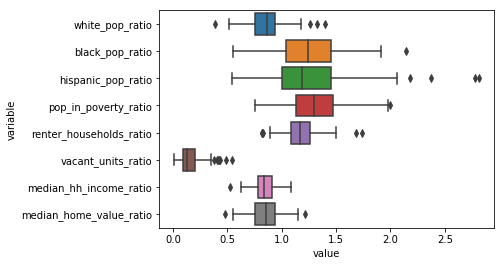

In [16]:
import seaborn as sns
sns.boxplot(data=plot_dat.query("facility_count > 10"), x="value", y="variable")